In [16]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

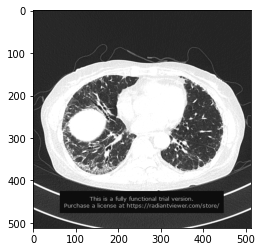

In [31]:
img=cv.imread("test/reticular/1200001.jpg")#转换成灰度图
img=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
plt.imshow(img,cmap="gray")

116.96821594238281
142.35591014182765
145.59580694506775
145.88707900784286
145.88707900784286


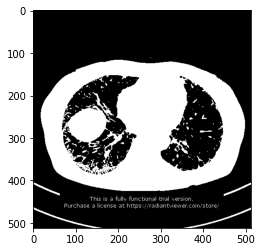

In [32]:
#全局阈值分割
meanGray=img.mean() #平均灰度值
ret,thresh=cv.threshold(img,meanGray,255,cv.THRESH_BINARY)
T=meanGray

result=[]
T_last=0
print(abs(T_last-T))
while abs(T_last-T)>0.1:
    T_last=T
    zero_value=0
    zero_num=0
    one_value=0
    one_num=0
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if thresh[i,j]==0:
                zero_num+=1
                zero_value+=img[i,j]
            else:
                one_num+=1
                one_value+=img[i,j]

    T=((zero_value/zero_num)+(one_value/one_num))/2 #计算前景和背景的平均灰度

    meanGray=T
    print(meanGray)
    ret,thresh=cv.threshold(img,meanGray,255,cv.THRESH_BINARY)
    result.append(thresh)
plt.imshow(thresh,cmap="gray")

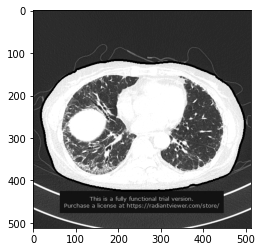

In [33]:
contours, hierarchy = cv.findContours(thresh,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
maxArea=0
maxContour=[]
index=0
for i in range(len(contours)):
    area = cv.contourArea(contours[i])
    if area>maxArea:
        maxArea=area
        maxContour=contours[i]

i=cv.drawContours(img, [maxContour], 0, (0,150,100), 3)
plt.imshow(i,cmap="gray")

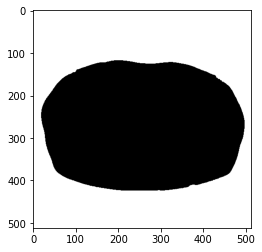

In [34]:
#判断点是否在最大连通区域轮廓内,制作掩模
mask=thresh.copy()
isIn=0
for i in range(thresh.shape[0]):
    for j in range(thresh.shape[1]):
        isIn=cv.pointPolygonTest(maxContour,(j,i),False)
        
        if isIn==1:
            mask[i,j]=0
        else:
            mask[i,j]=255
    
    
plt.imshow(mask,cmap="gray")

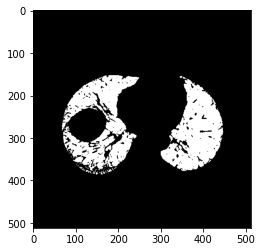

In [35]:
#取反
mask=~mask
result=mask-thresh
plt.imshow(result,cmap="gray")

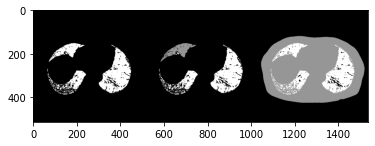

In [22]:
#闭运算
kernel=cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
closing=cv.morphologyEx(result,cv.MORPH_CLOSE,kernel)#使用闭操作消除图像内部的小孔
mask=np.zeros([thresh.shape[0]+2,thresh.shape[1]+2],np.uint8)
fill1=result.copy()
cv.floodFill(fill1,mask=mask,seedPoint=(180,200),newVal=150)
mask2=np.zeros([thresh.shape[0]+2,thresh.shape[1]+2],np.uint8)
fill2=result.copy()
cv.floodFill(fill2,mask=mask,seedPoint=(350,200),newVal=150)
plt.imshow(np.hstack((result,fill1,fill2)),cmap="gray")
mask3=np.zeros([thresh.shape[0]+2,thresh.shape[1]+2],np.uint8)

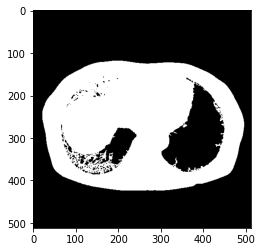

In [23]:
mask_all=mask[1:mask.shape[0]-1,1:mask.shape[0]-1]+mask2[1:mask2.shape[0]-1,1:mask2.shape[0]-1]+mask3[1:mask3.shape[0]-1,1:mask3.shape[0]-1]
image=np.zeros(img.shape,np.uint8)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if mask_all[i,j]>=1:
            image[i,j]=255
        else:
            image[i,j]=0
    
plt.imshow(image,cmap="gray")

In [24]:
contours, hierarchy = cv.findContours(image,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
#i=cv.drawContours(result,contours, -1, (0,150,100), 3)
#plt.imshow(i)

#找出2个最大面积的轮廓即为
maxArea1=0 #第一大
maxArea2=0 #第二大
maxContour1=[]
maxContour2=[]

for i in range(len(contours)):
    area = cv.contourArea(contours[i])
    if area>maxArea2 and area<maxArea1:
        maxArea2=area
        maxContour2=contours[i]
    elif area>maxArea1:
        maxArea2=maxArea1
        maxContour2=maxContour1.copy()
        maxContour1=contours[i]


#凸包
hull1 = cv.convexHull(maxContour1)
hull2 = cv.convexHull(maxContour2)
cv.polylines(img, [hull1],True,(0,150,100), 3)
plt.imshow(img)

TypeError: Expected Ptr<cv::UMat> for argument 'points'

In [14]:
#用2个凸包制作掩模
mask=thresh.copy()
isIn=0
for i in range(thresh.shape[0]):
    for j in range(thresh.shape[1]):
        isIn=cv.pointPolygonTest(hull1,(j,i),False)
        isIn2=cv.pointPolygonTest(hull2,(j,i),False)
        if isIn==1 or isIn2==1:
            mask[i,j]=0
        else:
            mask[i,j]=255
    
    
plt.imshow(mask,cmap="gray")

NameError: name 'hull2' is not defined

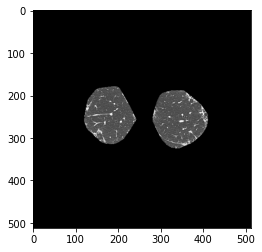

In [66]:
finalResult=np.zeros(img.shape,np.uint8)
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        if mask[i,j]==0:
            finalResult[i,j]=img[i,j]
        else:
            finalResult[i,j]=0
            
plt.imshow(cv.cvtColor(finalResult,cv.COLOR_BGR2RGB))